# Исследование причин неудачной рекламной компании

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года: лог сервера с данными об их посещениях, выгрузка их покупок за этот период, рекламные расходы.

<b>Цель исследования:</b>
 1. Узнать откуда приходят пользователи и какими устройствами они пользуются.
 2. Определить, сколько стоит привлечение пользователей из различных рекламных каналов.
 3. Определить, сколько денег приносит каждый клиент.
 4. Высчитать условия, в которых расходы на привлечение клиента окупаются.
 5. Вычислить, какие факторы мешают привлечению клиентов.
 
<b>Ход исследования</b>
 
Данные для исследования мы получим из трех датасетов. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу. 

Сначала проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе предобработки поищем возможность исправить все ошибки данных, которые не приведут к искажение конечного результата. Далее, создим сводные таблицы на основе необходимых данных, и приступим к проведению исследовательского анализа.
 
Таким образом, наше исследование пройдет в семь этапов:

 1. Обзор данных
 2. Предобработка данных
 3. Добавление функций для расчета и визуализации необходимых метрик
 4. Составление пользовательских профилей на основе имеющихся данных
 5. Проведение анализа источников, из которых приходят пользователи
 6. Оценка окупаемости рекламы
 7. Описание общего вывода и рекомендаций для отдела маркетинга

## Выгрузка данных и библиотек

In [1]:
import pandas as pd
import warnings
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
warnings.simplefilter("ignore")
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')
events = False

In [3]:
print(visits.head())
visits.info()

        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  

In [4]:
print(orders.head())
orders.info()

        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
print(costs.head())
costs.info()

           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Во всех трех датасетах отстутствуют пропуски, а также данные имеют корректный тип во всех столбцах, кроме столбцов с датами.

## Предобработка данных

### Поиск дубликатов

In [6]:
print('Количество явных дубликатов в visits:', visits.duplicated().sum())
print('Количество явных дубликатов в orders:', orders.duplicated().sum())
print('Количество явных дубликатов в costs:', costs.duplicated().sum())

Количество явных дубликатов в visits: 0
Количество явных дубликатов в orders: 0
Количество явных дубликатов в costs: 0


In [7]:
# Поиск неявных дубликатов в датасетах
print(visits[['User Id', 'Session Start']].duplicated().sum())
print(visits[['User Id', 'Session End']].duplicated().sum())
print(orders[['User Id', 'Event Dt']].duplicated().sum())
print(costs[['dt', 'Channel']].duplicated().sum())

0
0
0
0


### Поиск аномалий

In [8]:
# Поиск пользователей, зарегистрированных из нескольких регионов
visits.groupby('User Id')['Region'].nunique().sort_values(ascending=False).head(3)

User Id
599326          1
666759952851    1
666659346581    1
Name: Region, dtype: int64

Ни в одном из датасетов дубликатов, пропусков и аномалий не обнаружено. Все столбцы имеют верный тип данных, кроме тех, что содержат в себе информацию о дате и времени.

### Преобразование типов данных

In [9]:
# преобразование названий столбцов к нормальному виду
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

In [10]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [11]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [12]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [13]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функции для визуализации

In [15]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [18]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ

In [19]:
profiles = get_profiles(visits, orders, events, costs)
print(profiles.head(5))
print()
print('Минимальная дата привлечения пользователей: ', profiles['dt'].sort_values().min())
print('Максимальная дата привлечения пользователей: ', profiles['dt'].sort_values().max())

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  

Минимальная дата привлечения пользователей:  2019-05-01
Максимальная дата привлечения пользователей:  2019-10-27


Минимальная и максимальная даты привлечения пользователей совпадают с информацией по данным датасетам. На первый взгляд аномалий не обнаружено.

In [20]:
region_payers = profiles.groupby('region')['payer'].agg(['count','mean'])
region_payers.sort_values(by='mean')

,count,mean
region,,
France,17450,0.037994
UK,17575,0.039829
Germany,14981,0.041119
United States,100002,0.069019


Наибольшее число пользователей по регионам наблюдается в США и составляет две трети от общего числа пользователей. Соотношение количества платящих пользователей от общего количества в разных странах не сильно отличается, однако в США показатель выше других стран на 3%.

In [21]:
device_payers = profiles.groupby('device')['payer'].agg(['count','mean'])
device_payers.sort_values(by='mean')

,count,mean
device,,
PC,30455,0.050468
Android,35032,0.058518
iPhone,54479,0.062079
Mac,30042,0.063644


Пользователи отдают большее предпочтение устройствам iPhone. Наименьший показатель наблюдается у клиентов PC и Mac. Конверсия пользователей в платящих на всех устройствах одинакова - около 6%.

In [22]:
channel_payers = profiles.groupby('channel')['payer'].agg(['count','mean'])
channel_payers.sort_values(by='mean')

,count,mean
channel,,
organic,56439,0.020553
OppleCreativeMedia,8605,0.027077
LeapBob,8553,0.030633
MediaTornado,4364,0.035747
YRabbit,4312,0.038265
WahooNetBanner,8553,0.052964
RocketSuperAds,4448,0.079137
TipTop,19561,0.096007
lambdaMediaAds,2149,0.104700


Наилучшая конверсия наблюдается у канала FaceBoom и составляет целых 12% от числа привлеченных по этому каналу пользователей. Также можно выделить канал TipTop. Хоть конверсия и хуже на 3% по сравнению с каналом FaceBoom, однако число пользователей перешедших по этому рекламному источнику занимает второе место среди всех рекламных каналов.

При составлении пользовательских профилей проблем с данными не обнаружено. Можно заметить, что основная часть аудитории приложения - американцы.

## Маркетинг

In [23]:
print('Общая сумма расходов на маркетинг:', round(costs['costs'].sum(), 2))
channel_costs = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs')
print(channel_costs)

Общая сумма расходов на маркетинг: 105497.3
                       costs
channel                     
YRabbit               944.22
MediaTornado          954.48
lambdaMediaAds       1557.60
LeapBob              1797.60
RocketSuperAds       1833.00
OppleCreativeMedia   2151.25
AdNonSense           3911.25
WahooNetBanner       5151.00
FaceBoom            32445.60
TipTop              54751.30


На рекламные каналы FaceBoom и TipTop ушла большая часть рекламного бюджета компании - 30.75% и 50.9% соответственно.

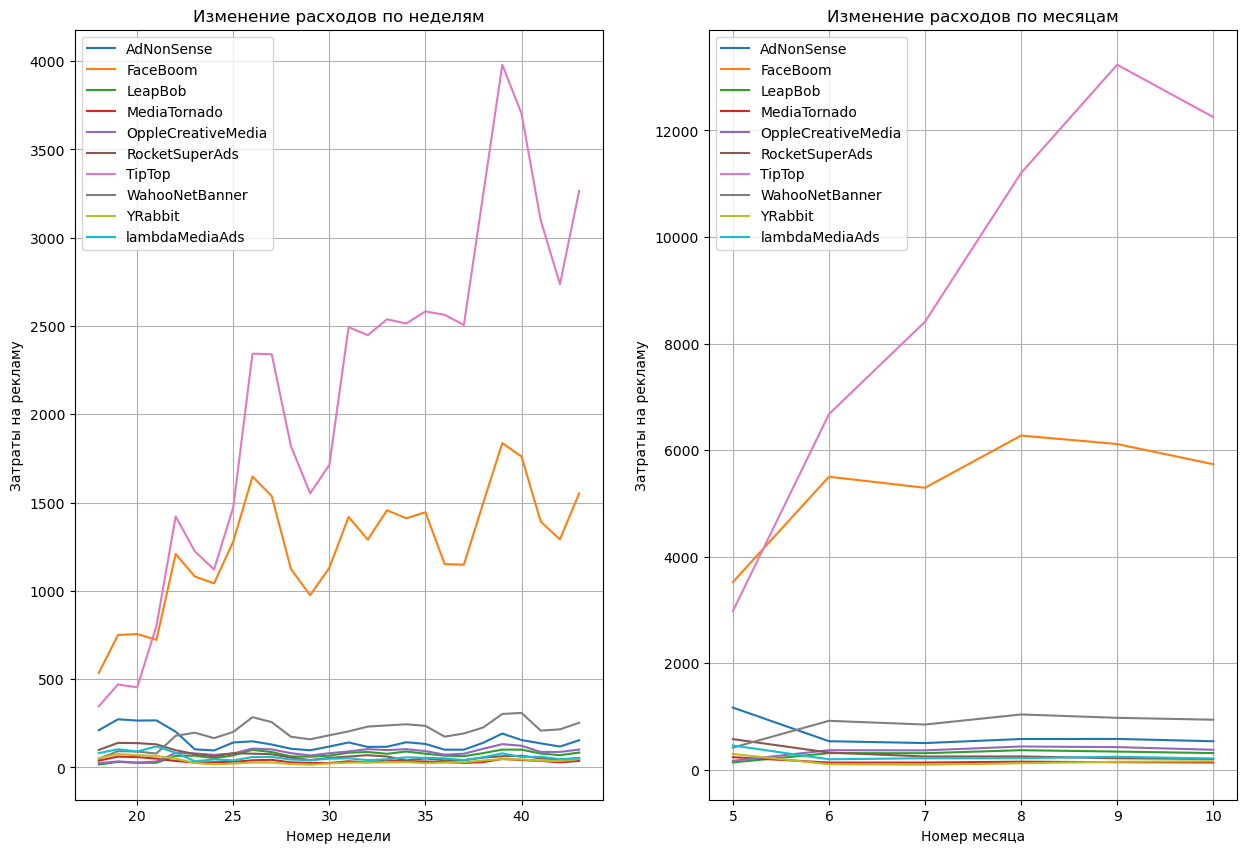

In [24]:
plt.figure(figsize=(15, 10))
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month
costs_w = costs.pivot_table(index='channel', columns='week', values='costs', aggfunc='sum')
ax1 = plt.subplot(1, 2, 1)
costs_w.T.plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Номер недели')
plt.ylabel('Затраты на рекламу')
plt.title('Изменение расходов по неделям')

costs_m = costs.pivot_table(index='channel', columns='month', values='costs', aggfunc='sum')
ax2 = plt.subplot(1, 2, 2)
costs_m.T.plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('Номер месяца')
plt.ylabel('Затраты на рекламу')
plt.title('Изменение расходов по месяцам')
plt.show()

На графике видно ежемесечное спонсирование в рекламу из канала TipTop. Бюджет по каналу FaceBoom также был увеличен в июне, но по сравнению с каналом TipTop, в FaceBoom в дальнешем рекламный бюджет не меняется. Остальные источники имеют стабильно низкий уровень затрат.

In [25]:
cac_channel = profiles.groupby('channel').agg({'user_id': 'nunique'}).merge(
    channel_costs, on='channel', how='left').fillna(0)
cac_channel['cac'] = cac_channel['costs'] / cac_channel['user_id']
print(cac_channel['cac'].sort_values())
print('Средний САС по всем каналам:', round(cac_channel['cac'].mean(), 2))

channel
organic               0.000000
LeapBob               0.210172
MediaTornado          0.218717
YRabbit               0.218975
OppleCreativeMedia    0.250000
RocketSuperAds        0.412095
WahooNetBanner        0.602245
lambdaMediaAds        0.724802
AdNonSense            1.008054
FaceBoom              1.113286
TipTop                2.799003
Name: cac, dtype: float64
Средний САС по всем каналам: 0.69


In [26]:
print(profiles.loc[profiles['channel'].isin(['TipTop', 'FaceBoom']), 'region'].unique())

['United States']


Показатели САС также в пределах нормы. Наибольший показатель у канала TipTop - 2.8. Второе и третье место занимают FaceBoom и AdNonSense с ценой за пользователя 1.11 и 1 соответственно. В остальных рекламных каналах цена за пользователя меньше 1.

Две самые дорогие рекламные компании расчитаны на американскую аудиторию. Значит большая часть рекламного бюджета ушла на регион США.

## Оценка окупаемости рекламы

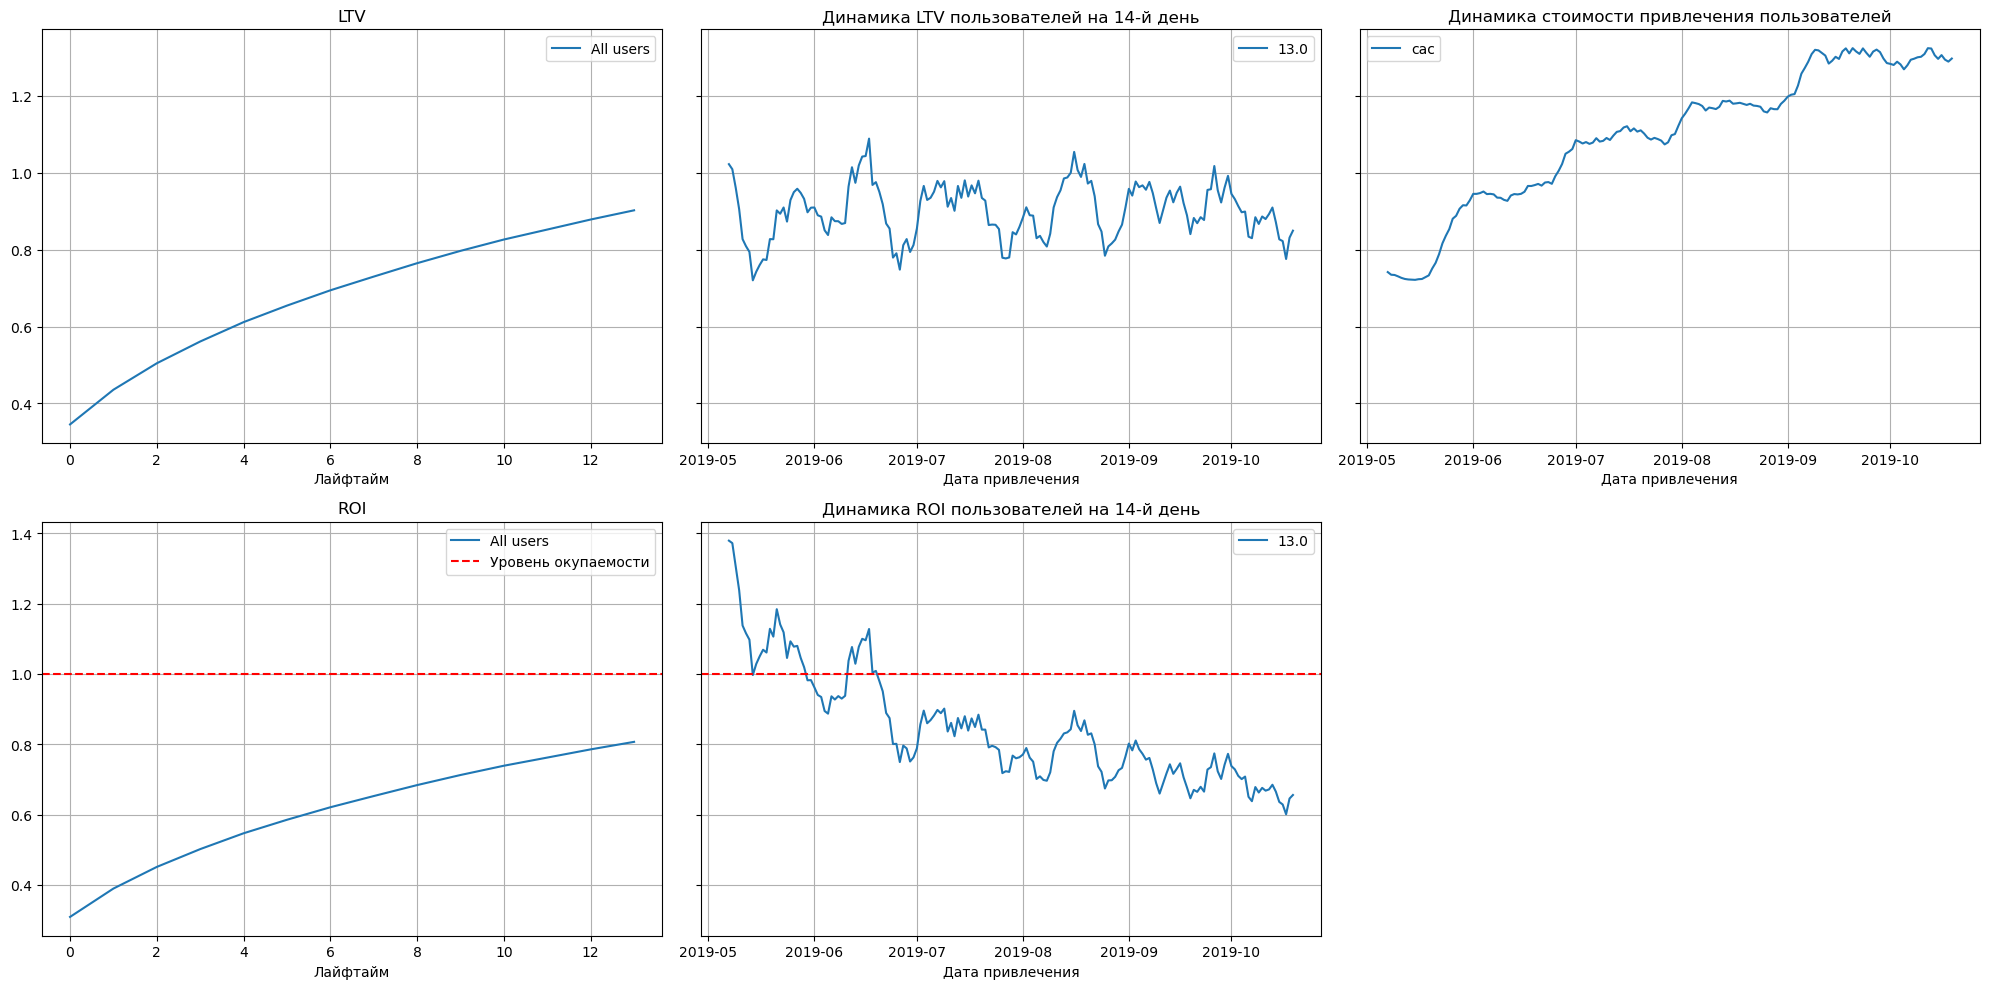

In [27]:
profiles = profiles.query('channel != "organic"')
dimensions=[]
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14 # горизонт анализа

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

По графикам LTV, ROI и CAC можно сделать такие выводы
 - показатель LTV стабилен, значит качество пользователей не менятся.
 - САС со временем растет
 - Реклама себя не окупает. К концу второй недели показатель ROI достигает 80%, а по динамике ROI видно,что показатель ухудшается со временем.

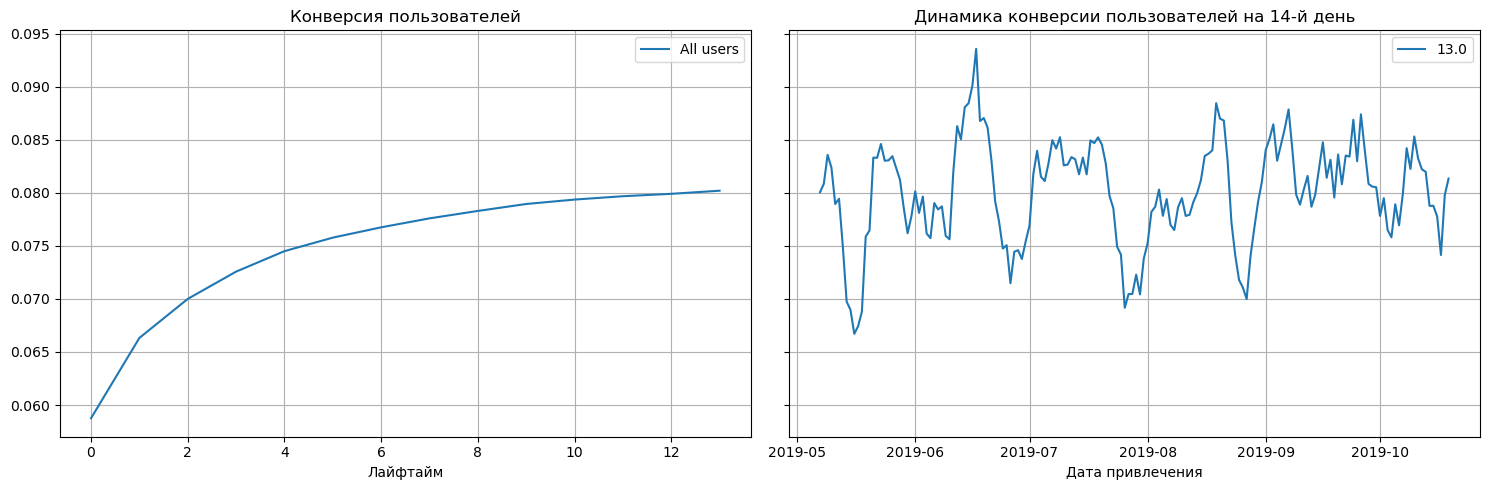

In [28]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

График конверсии в пределах нормы. По динамики конверсии сделать однозначных выводов нельзя. Значения колеблются в среднем от 70 до 90 процентов.

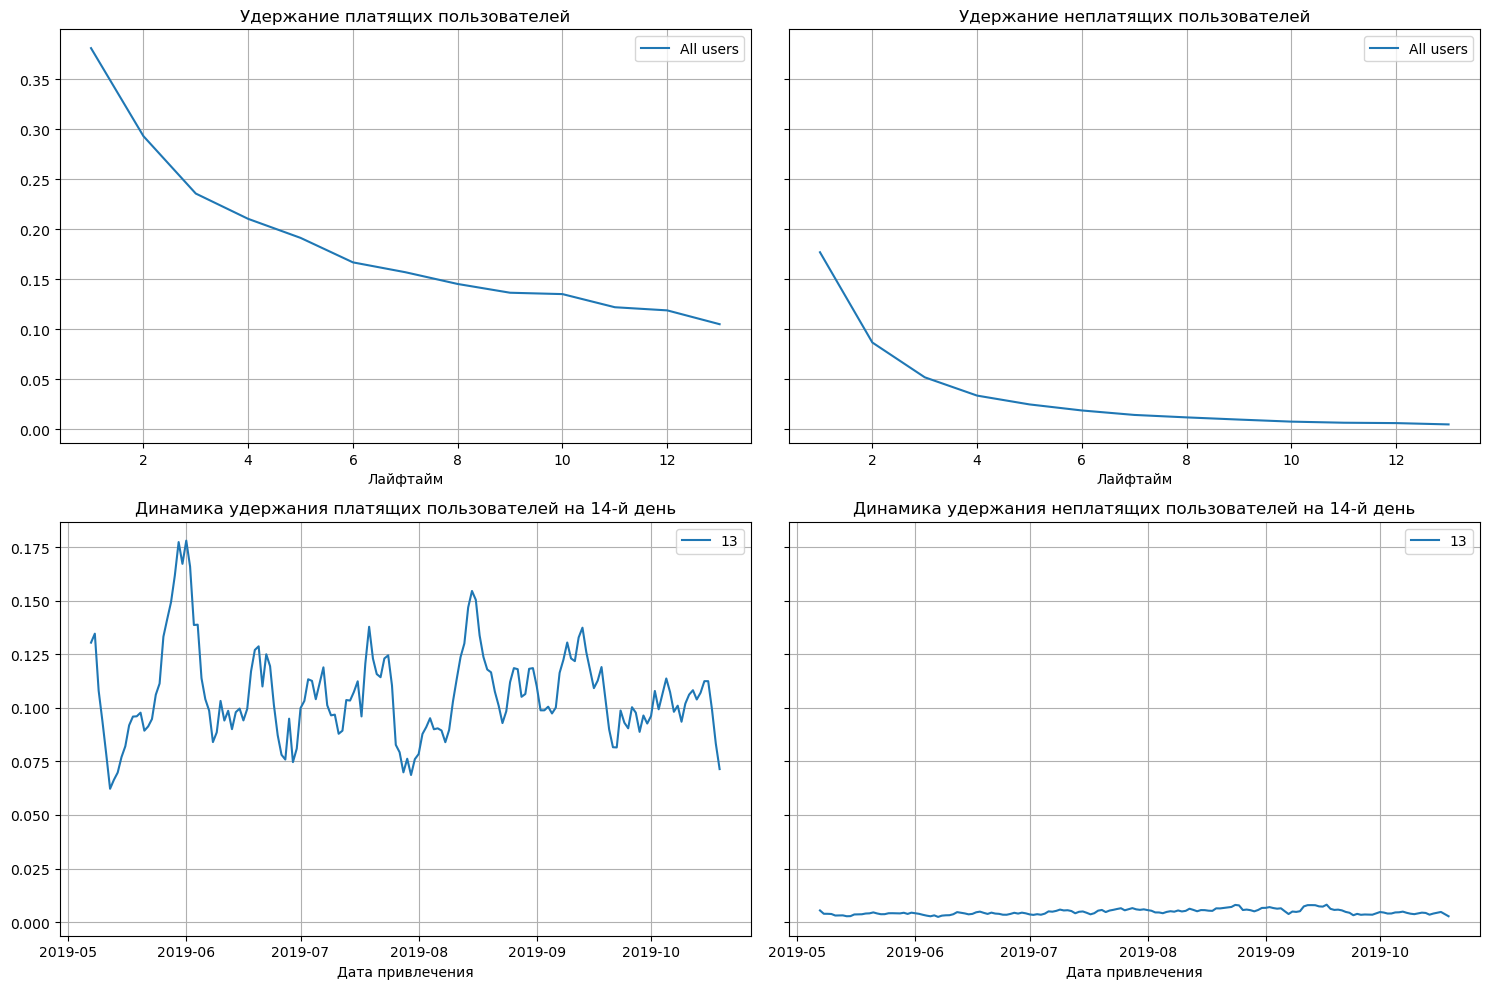

In [29]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days, window=7)

Графики удержания для платящих и неплатящих пользователей без аномалий.

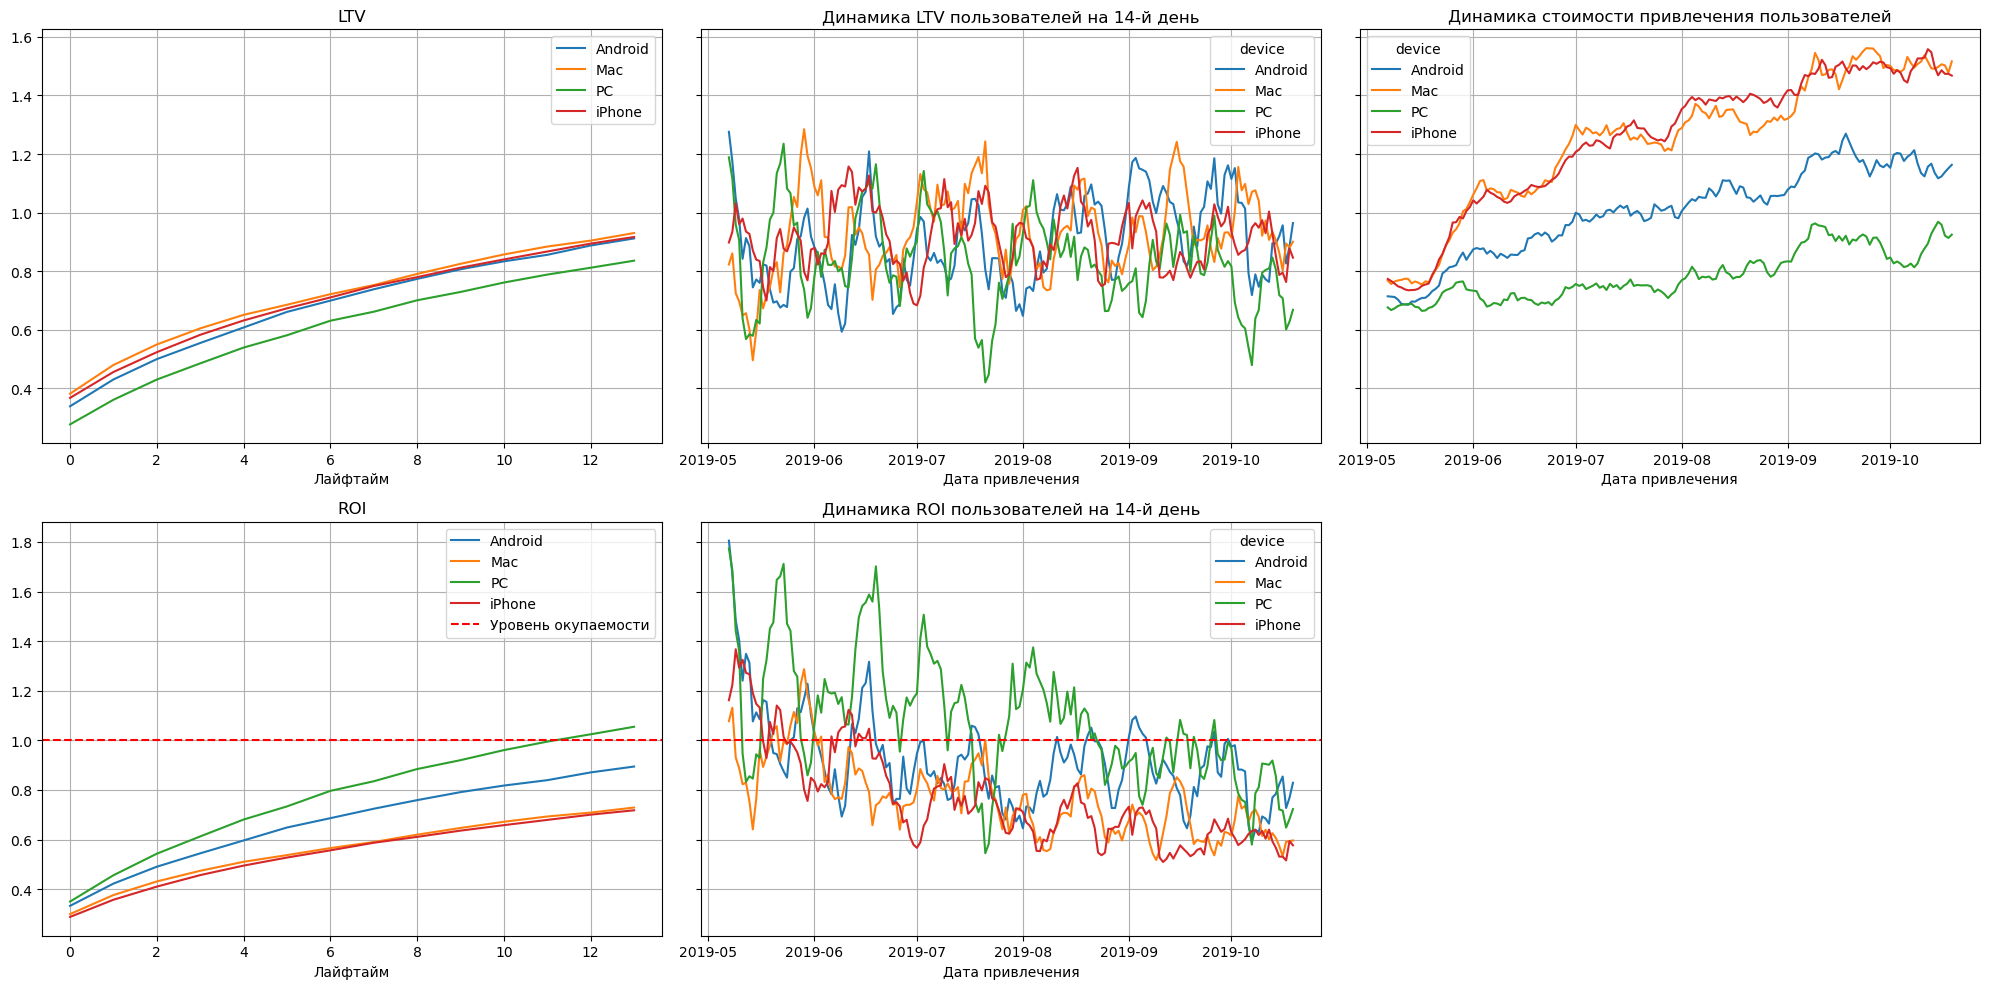

In [30]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7) 

С разбивкой по девайсам можно сказать следующее:
 - Пользователи PC окупают затраты на рекламу не более, чем на 5%, у пользователей Android показатель ROI около 90%, а пользователи Mac и iPhone имеют худшие показатели ROI - 70% к концу второй недели.
 - Ситуация со стоимостью привлечения противоположная - на пользователей Mac и iPhone уходит наибольшая часть бюджета рекламы. Меньше всего идет на пользователей PC.
 - Показатель LTV для PC не сильно уступает другим платформам.

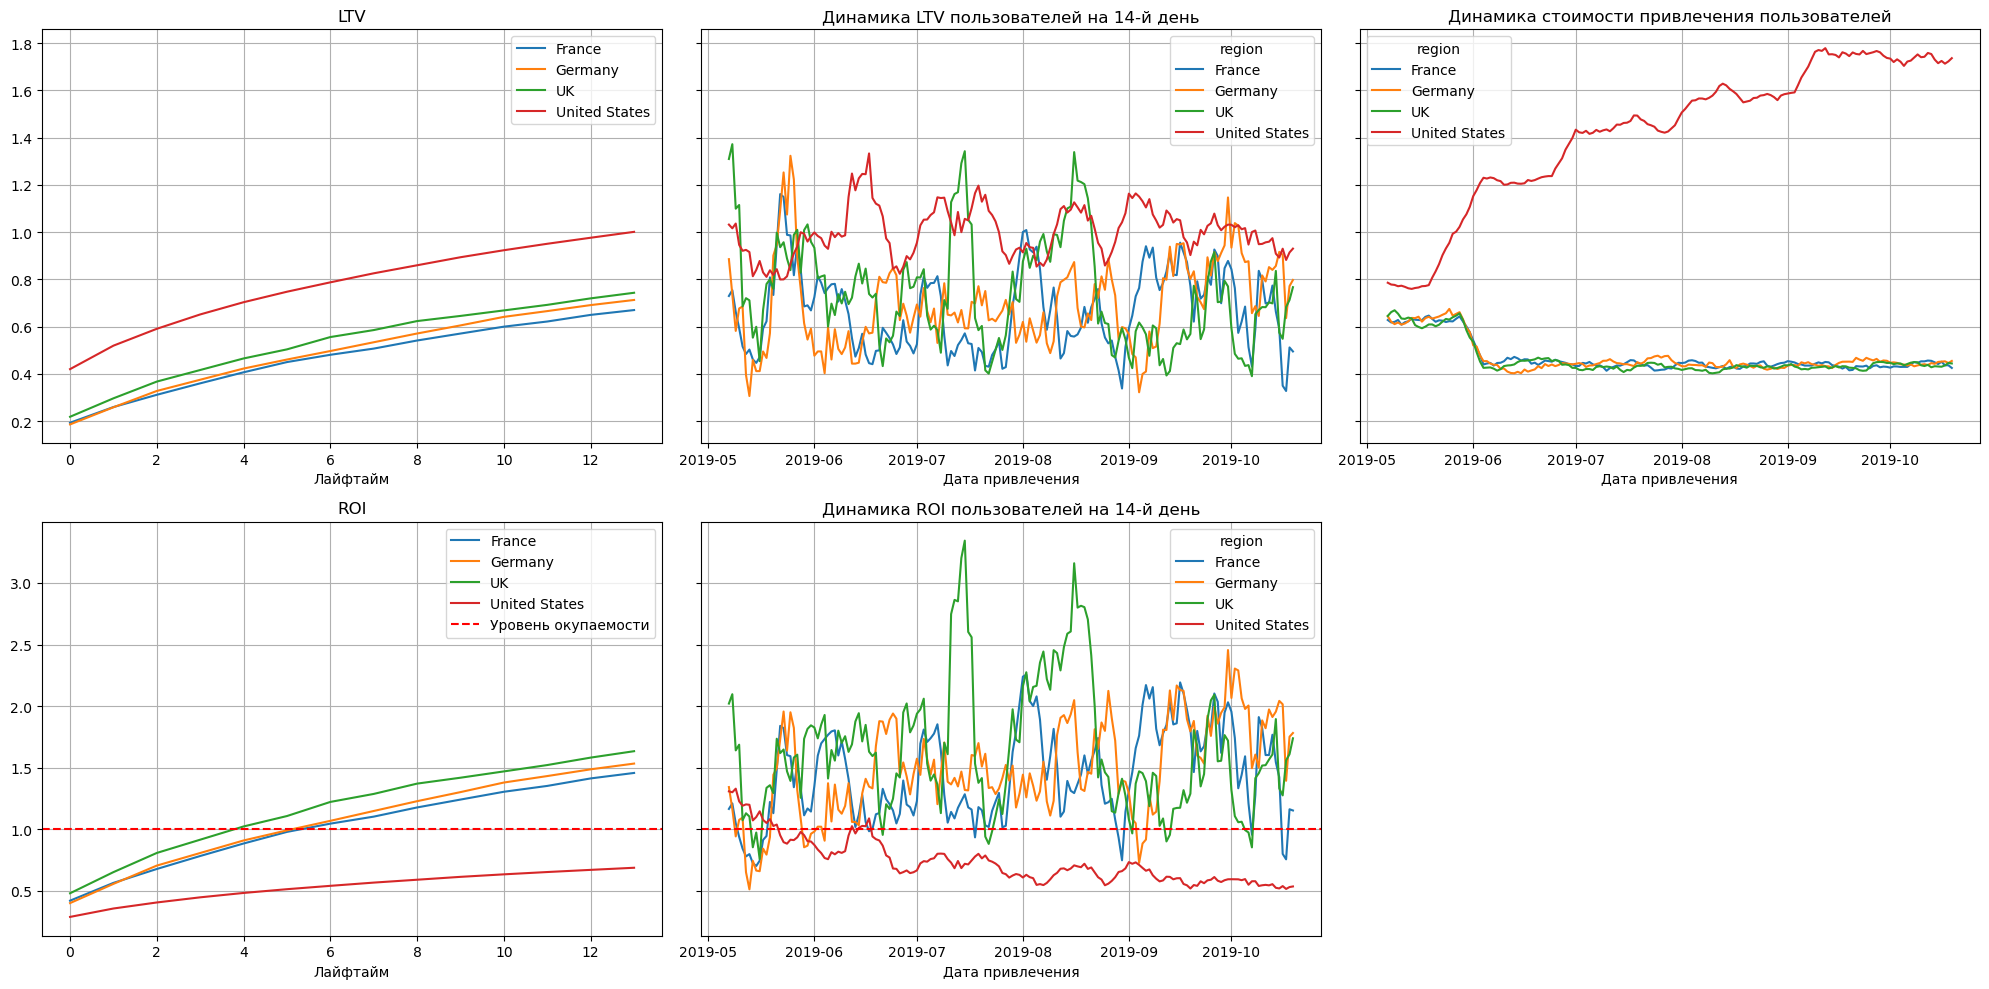

In [31]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7) 

На графиках с разбивкой по регионам видна возможная причина плохой окупаемости рекламы: пользователи из США не окупают затраты на рекламу. По динамике ROI также видно, что с увеличением затрат на рекламу в США падает показатель ROI.

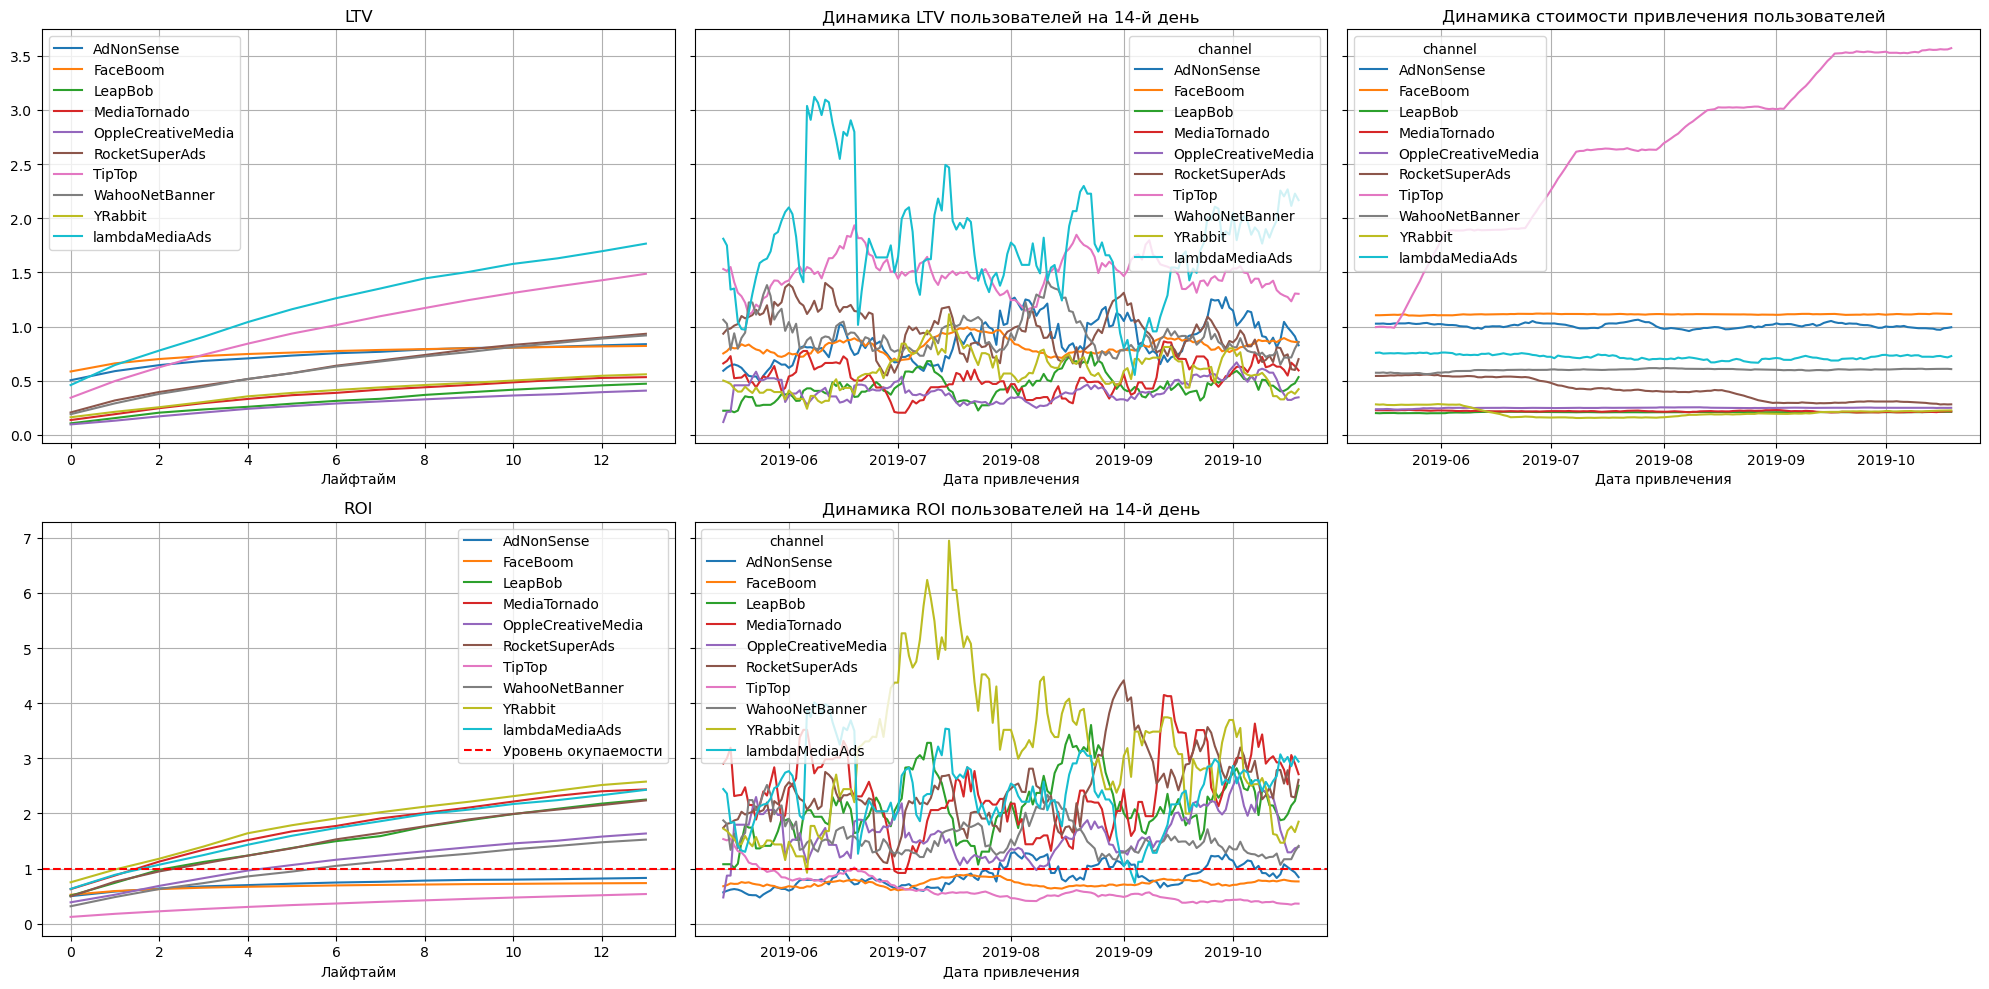

In [32]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

В разбивке по рекламам видно, что три рекламные компании TipTop, FaceBoom и AdNonSence с самым высокими показателями САС себя не окупают.

Проверим причины плохого показателя ROI для региона США.

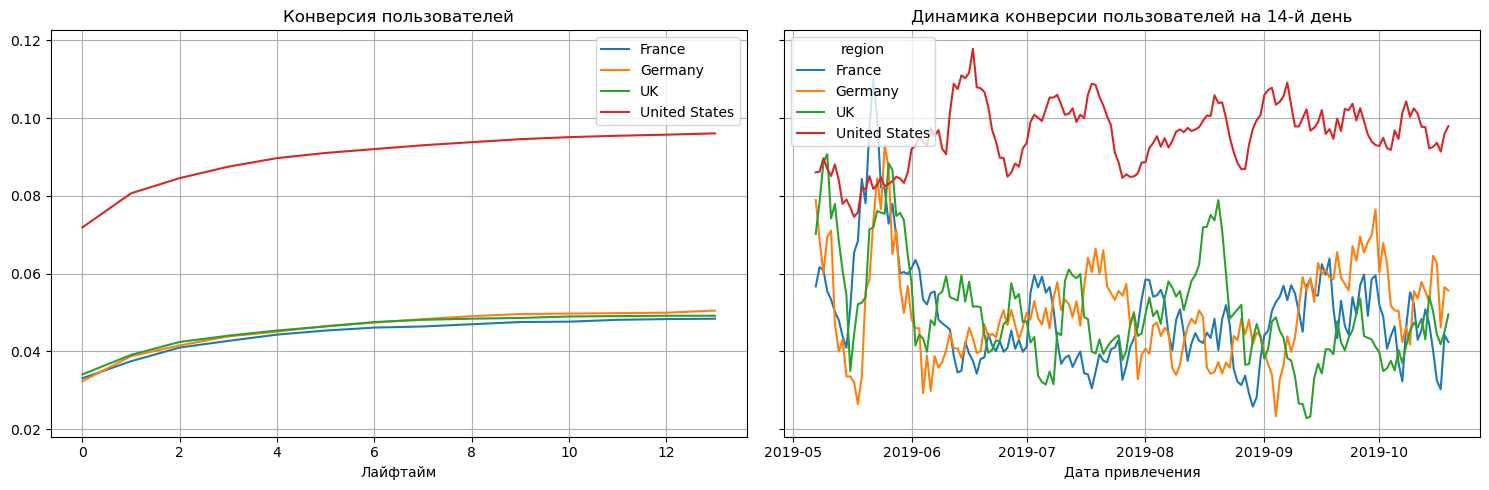

In [33]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

Судя по графикам пользователи из Америки конвертируются очень хорошо, причем постоянно. Скорее всего дело в удержании.

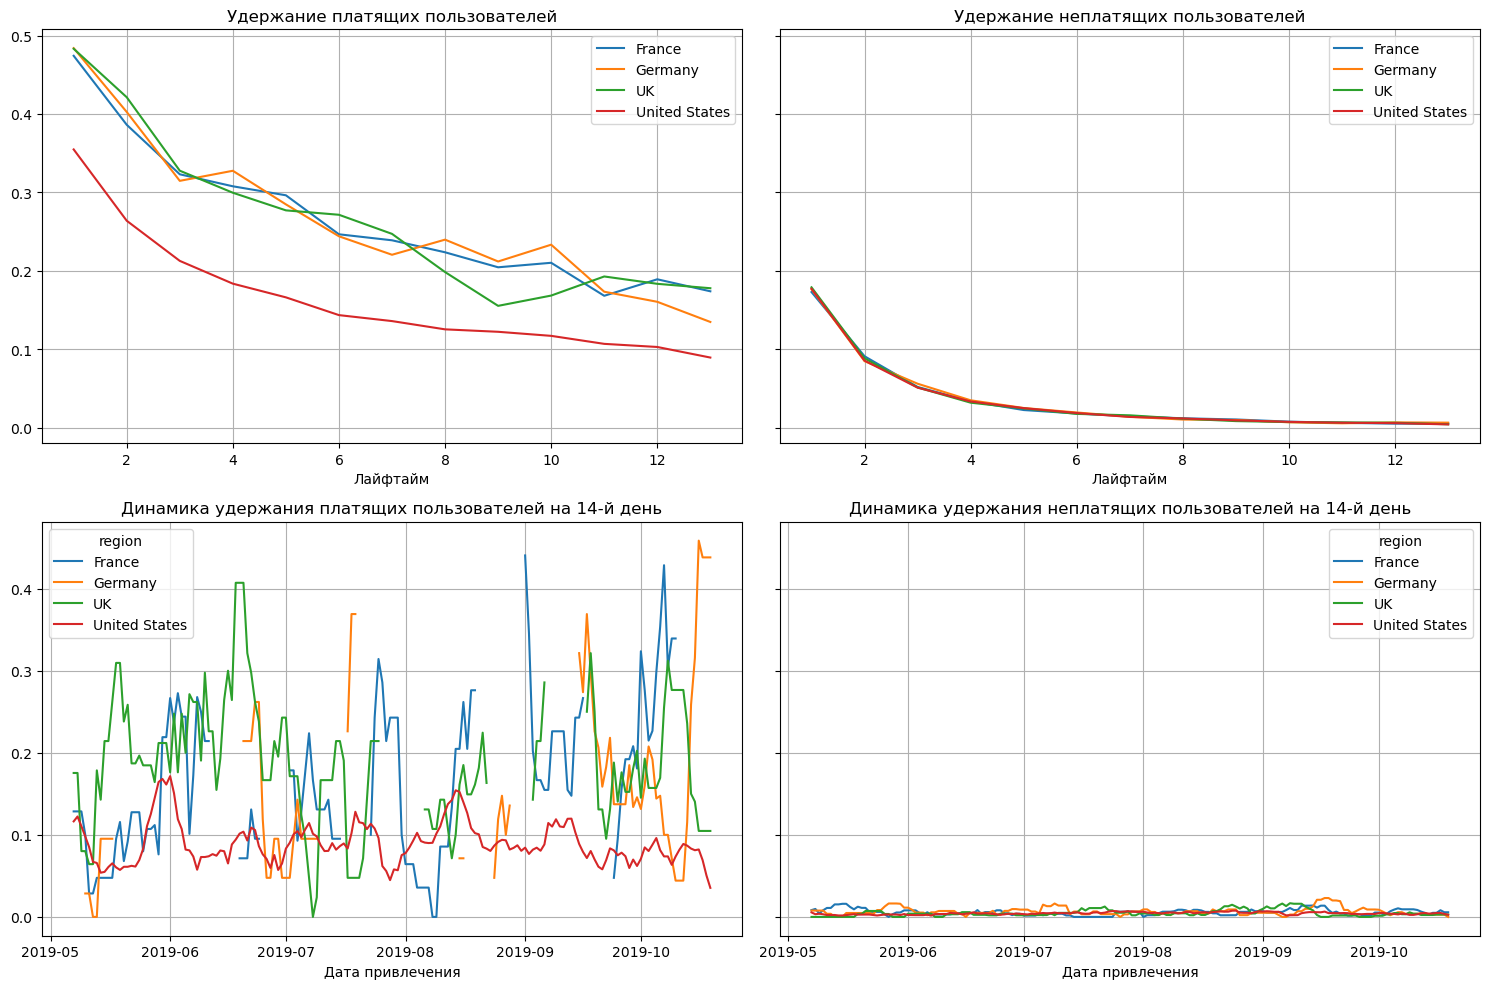

In [34]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days, window=7)

Судя по графикам, удержание платящих пользователей США в среднем ниже показателя других регионов на 15%. Разница не настолько существенная, чтобы делать какие то выводы.

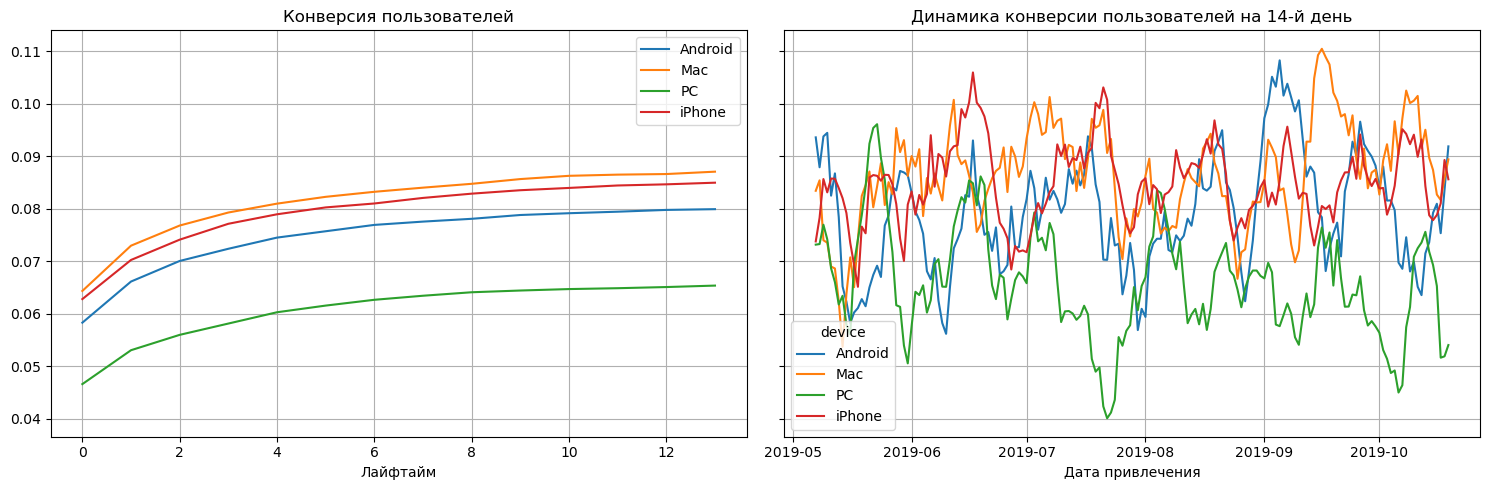

In [35]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

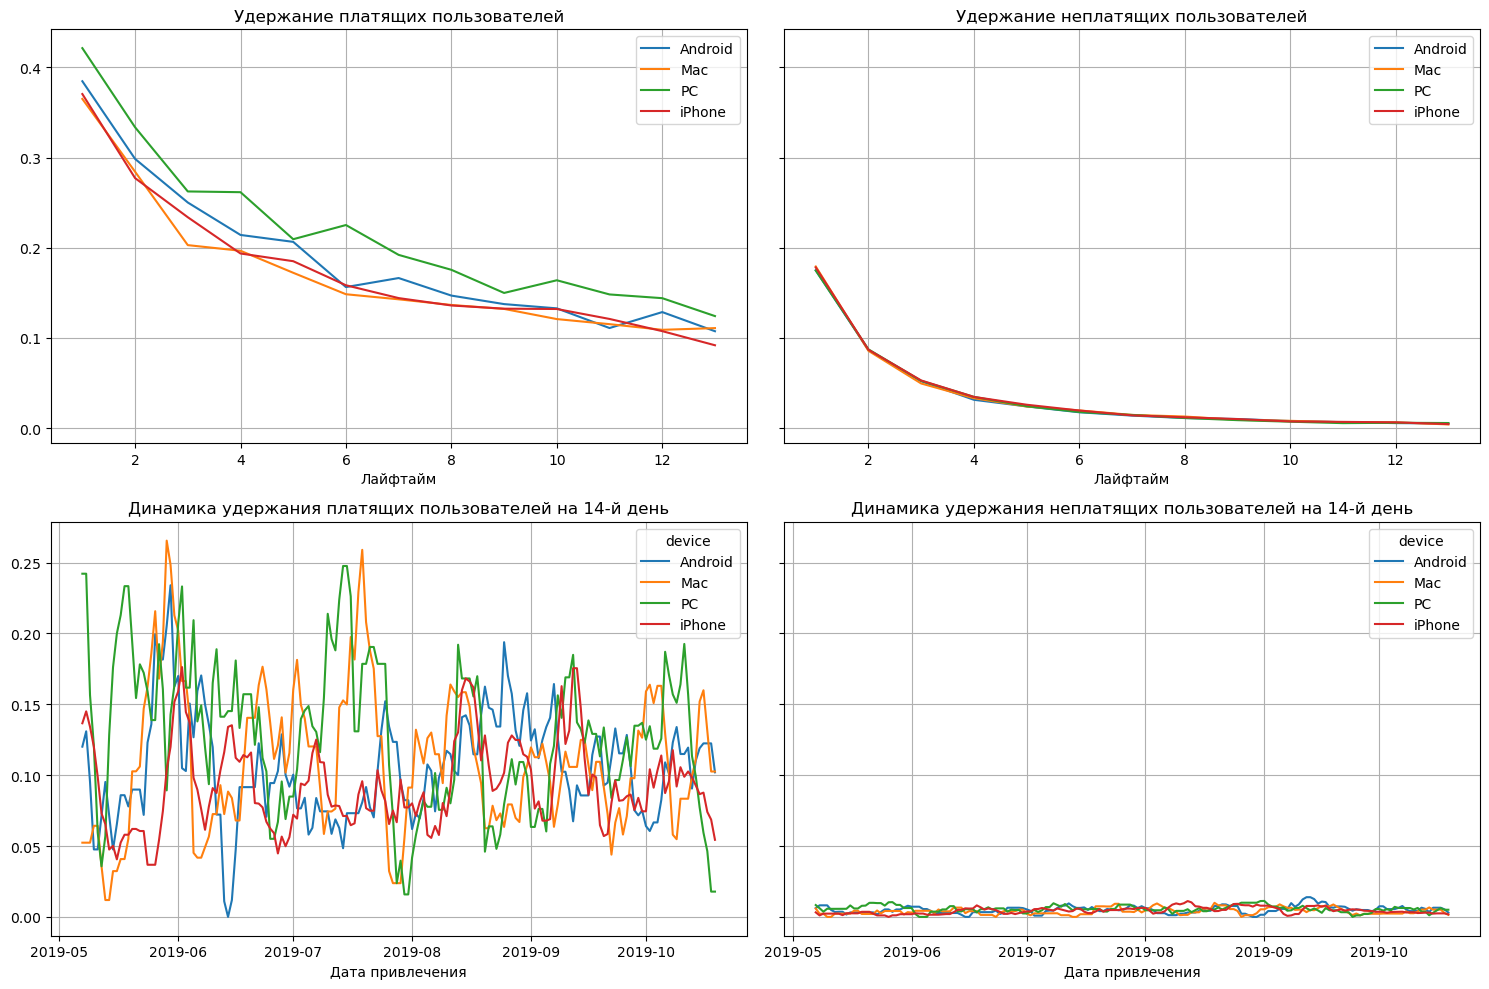

In [36]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days, window=7)

In [37]:
print(profiles.query('device == "Mac"').groupby('region')['user_id'].agg('count'))
print()
print(profiles.query('device == "iPhone"').groupby('region')['user_id'].agg('count'))

region
France            1163
Germany           1020
UK                1086
United States    15424
Name: user_id, dtype: int64

region
France            2198
Germany           1862
UK                2274
United States    27548
Name: user_id, dtype: int64


По графикам конверсии и удержания с разбивкой по устройствам аномалий не обнаружено. Также можно заметить, что 80% пользователей Mac и iPhone из США. Эта информация пригодится при составлении причин плохой окупаемости рекламы. Осталось проверить данные с разбивкой по рекламным каналам.

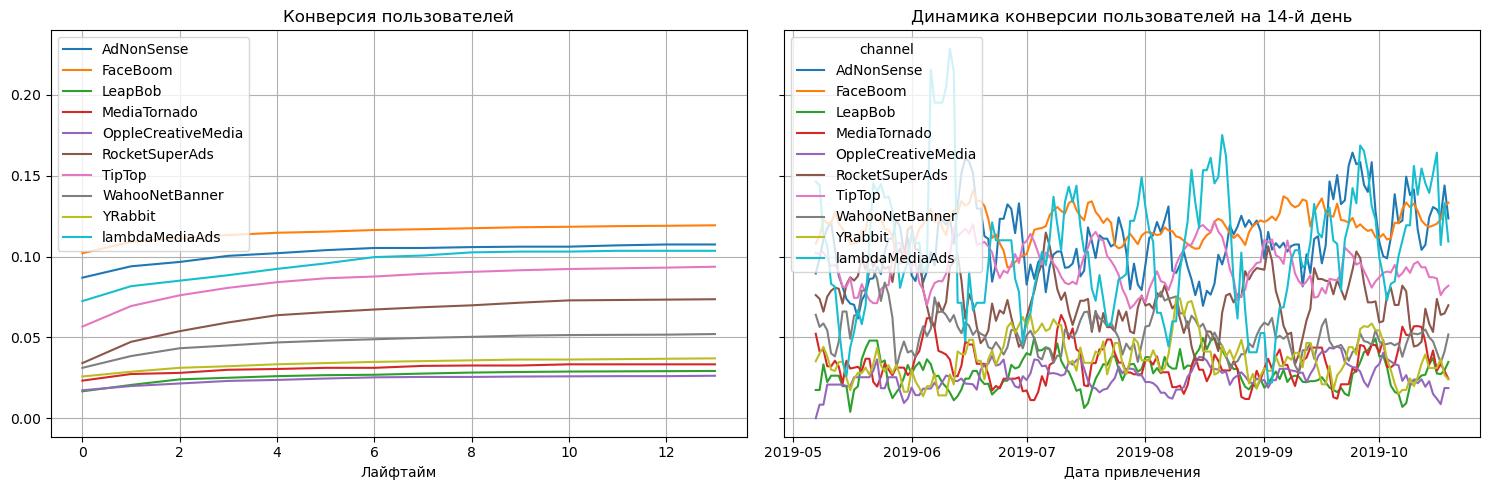

In [38]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

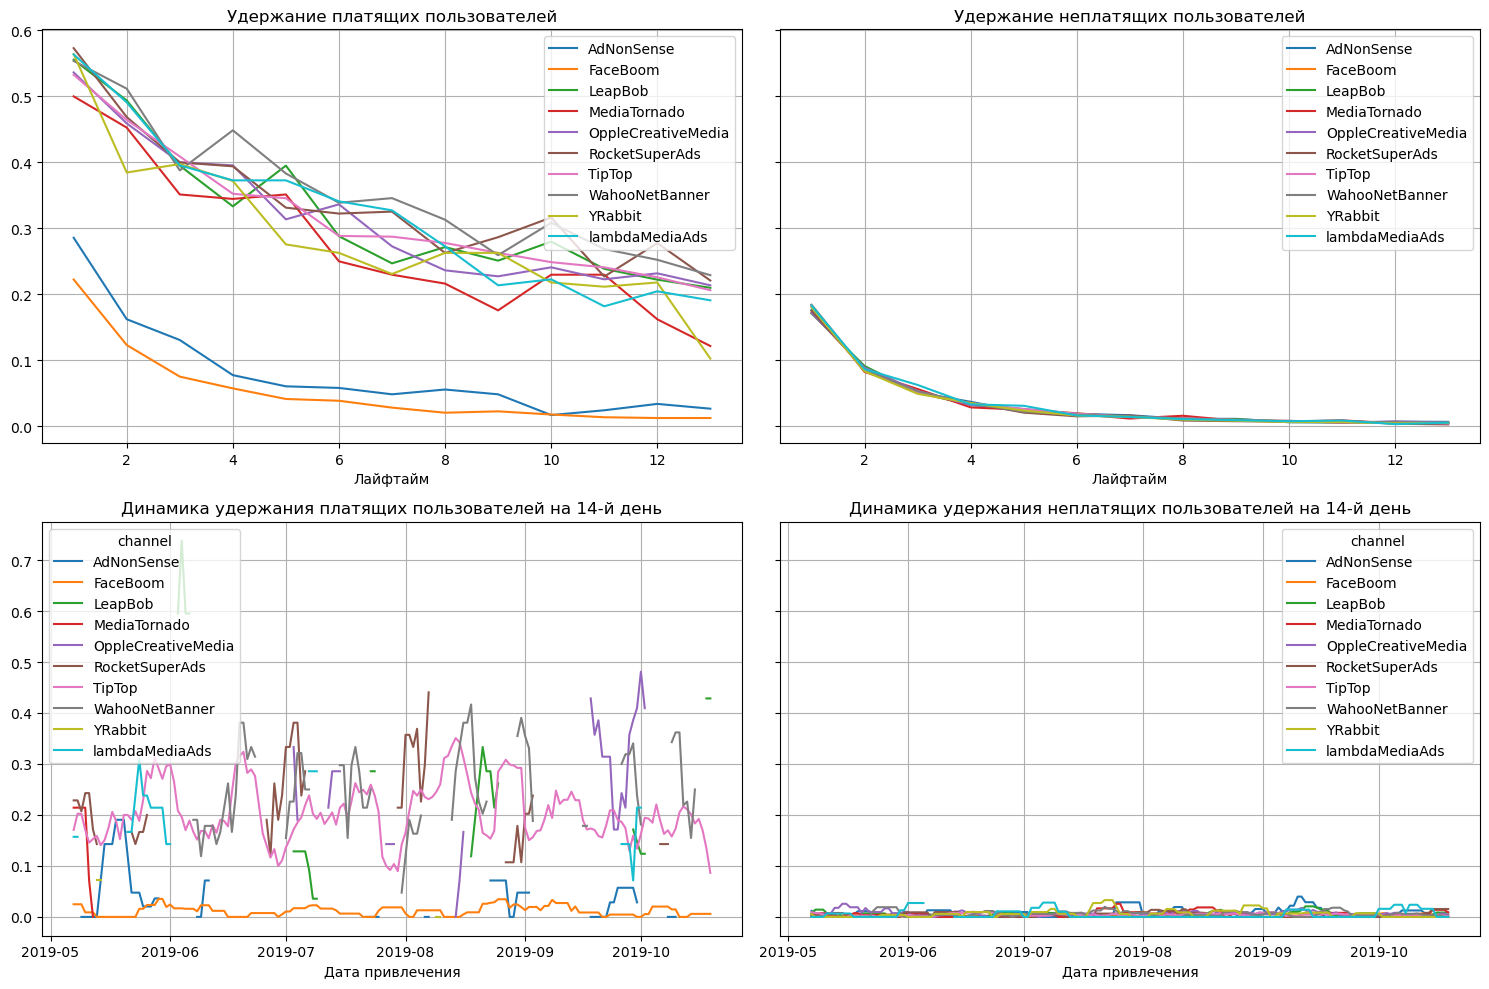

In [39]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days, window=7)

Вот и самая вероятная причина плохой окупаемости в Америке. Показатели удержания пользователей привлеченных по каналам AdNonSense и FaceBoom в среднем ниже показателей других реклам на 30%. Также видно, что ни динамика конверсии, ни динамика удержания пользователей привлеченных по каналу TipTop не меняются, несмотря на увеличение САС со временем.

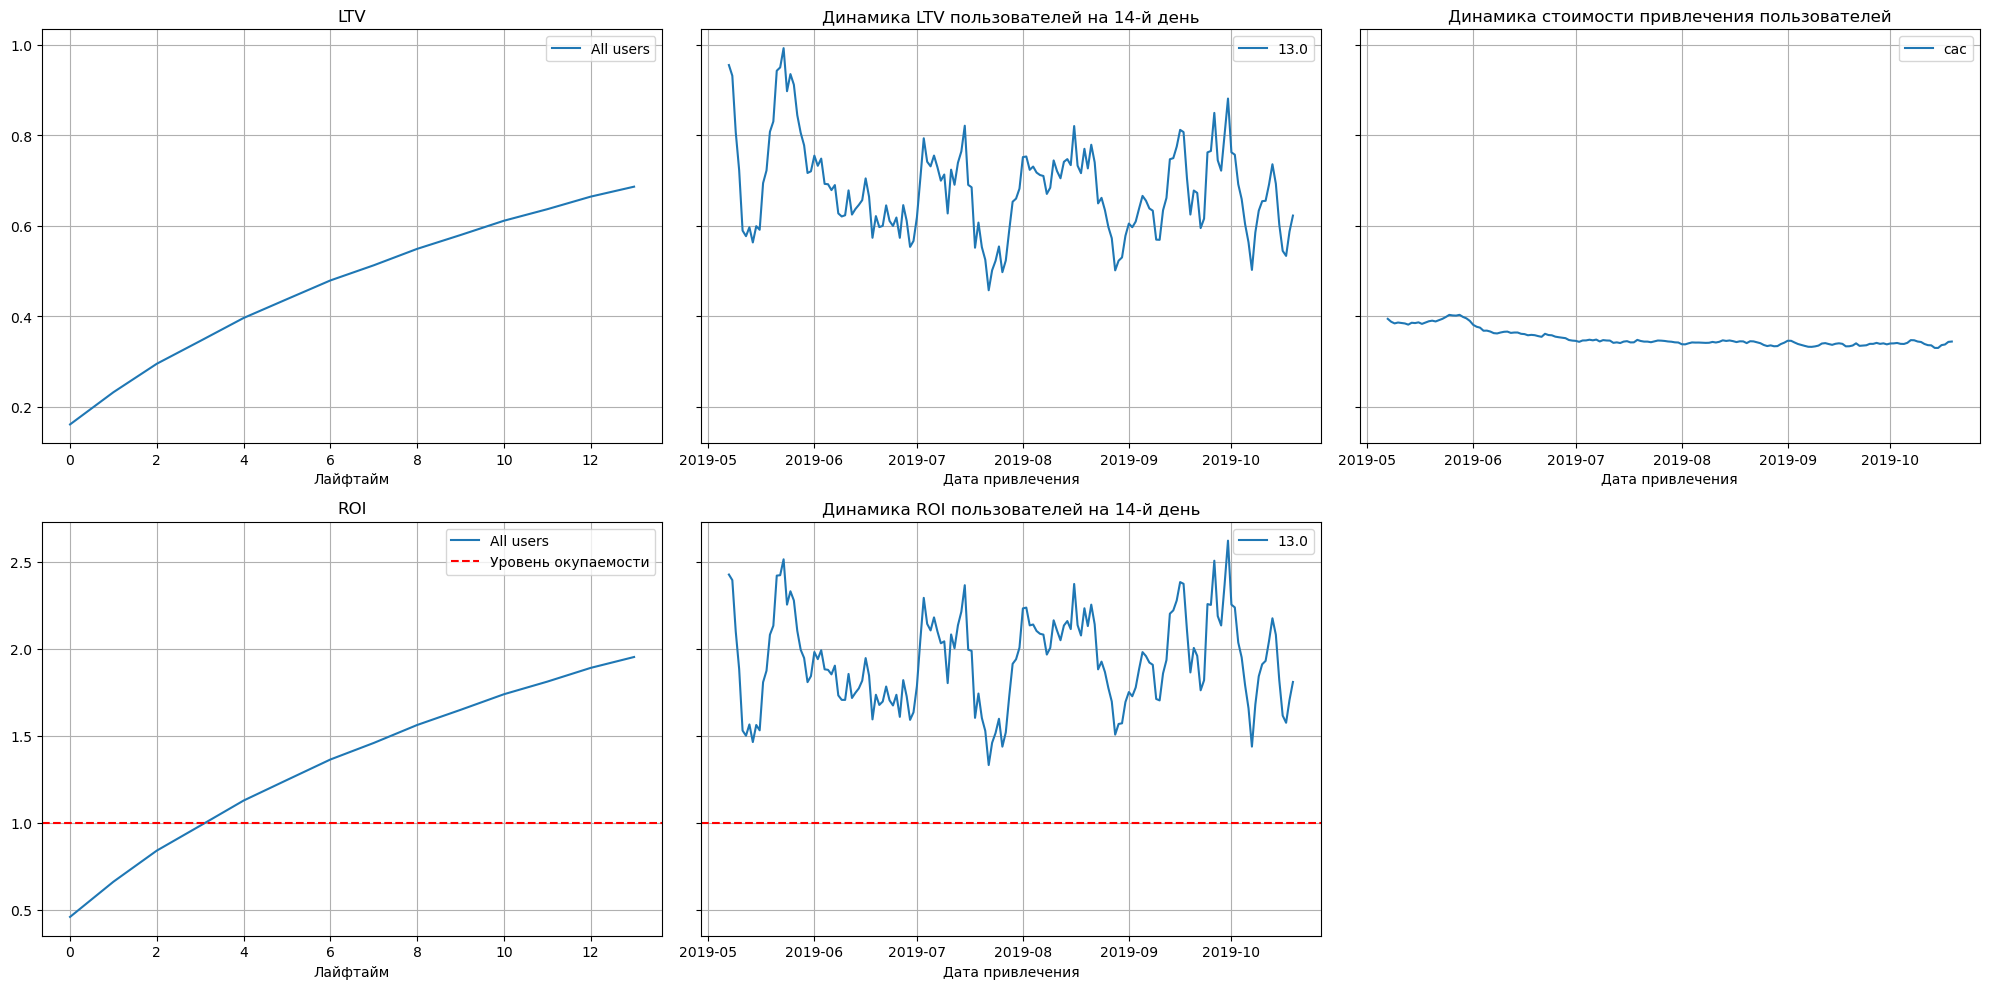

In [40]:
profiles = profiles.query('channel != "AdNonSense"')
profiles = profiles.query('channel != "FaceBoom"')
profiles = profiles.query('channel != "TipTop"')
dimensions=[]

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

Исключая убыточные рекламные каналы, видна большая разница в показателях:
 - Показатель LTV все также стабилен
 - САС не растет со временем
 - ROI к концу 14 дня достигает почти достигает отметки в 200%, вместо 80% у изначальных данных.

Подводя итоги:
 1. В целом реклама себя не окупает.
 2. Наибольшая часть рекламного бюджета не окупилась: показатели ROI и CAC в США прямо противоположны. Отдельное внимание стоит уделить трем самым затратным рекламным компаниям: показатели удержания в них ниже остальных на 30%. С устройствами ситуация не совсем однозначная: ROI для пользователей Mac и iPhone уступают PC и Android, но эта разница вызвана скорее плохой окупаемостью рекламы в Америке, нежели проблемами связанными с девайсами.
 3. Проблемы окупаемости напрямую связаны с рекламными каналами, на которые уходит большая часть бюджета.

## Общий вывод

Причина плохой окупаемости в США связана с большими вложениями в рекламные каналы в этом регионе, а именно:
 1. Для канала TipTop увеличение показателя САС со временем никак не влияет на удержание и конверсию пользователей, что говорит о напрасно потраченных инвестиция в этот канал.
 2. Коэффициент удержания у пользователей, привлеченных по каналам FaceBoom и AdNonSense на 30% ниже показателей у других каналов.
 
Наилучшим решением для проекта будет отказаться от рекламных компаний по каналам FaceBoom и AdNonSense и перераспределить рекламный бюджет канала TipTop.